## Referenced from
https://www.youtube.com/watch?v=moydeKyFF6M

## Importing libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display as ipd
import math
import warnings
warnings.filterwarnings('ignore')

## Audio file

In [5]:
#sound = 'data/TienLenVietNamOi_sample.mp3'
sound = 'data/piano_with_rain.mp3'

In [6]:
duration = 24
per_sec = 22050
y_sound, sr = librosa.load(sound, sr=per_sec, duration=duration)
ipd.Audio(y_sound, rate=sr)

In [7]:
y_sound

array([-0.00379917, -0.00205804,  0.00812829, ..., -0.01931162,
       -0.01874658, -0.01708545], dtype=float32)

In [8]:
print(len(y_sound))

529200


In [9]:
print(duration * per_sec)

529200


In [10]:
sr

22050

## Short-Time Fourier Transform (STFT)

In [12]:
# 3. Compute Short-Time Fourier Transform (STFT)
FRAME_SIZE = 1024
HOP_LENGTH = 512

# Returns a matrix of complex numbers
sound_stft = librosa.stft(y_sound, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH)

In [13]:
sound_stft

array([[ 2.4870578e-02+0.00000000e+00j, -2.2519279e-02+0.00000000e+00j,
         8.4853061e-03+0.00000000e+00j, ...,
        -9.9838895e-01+0.00000000e+00j,  4.7751361e-01+0.00000000e+00j,
        -2.3990834e-01+0.00000000e+00j],
       [-2.6019601e-02+3.69908451e-03j,  3.9364129e-02+2.19116341e-02j,
         1.9733185e-02+1.29547585e-02j, ...,
         5.9061033e-01-1.82315648e-01j, -5.5252600e-01+5.75064898e-01j,
         1.5969132e-01-5.63445568e-01j],
       [ 4.1979965e-02-1.40122352e-02j, -5.5598211e-02-1.52811725e-02j,
        -1.0928916e-01-1.42181991e-02j, ...,
         5.6396533e-02-6.99056312e-02j,  4.4765308e-01-9.17922780e-02j,
        -1.5445930e-01+8.75976235e-02j],
       ...,
       [ 3.6311842e-04+4.34754984e-05j,  3.7637778e-07+2.12790860e-06j,
         2.9711734e-06-9.31837917e-07j, ...,
        -3.1916109e-06+8.70142856e-07j,  1.5436727e-06+4.25611870e-06j,
        -2.4352819e-03-1.65303529e-03j],
       [-3.6366677e-04-2.19618851e-05j, -1.0433538e-06+2.81303496e-0

In [14]:
print(sound_stft.shape)

(513, 1034)


## Separate STFT into Magnitude & Phase Spectrograms

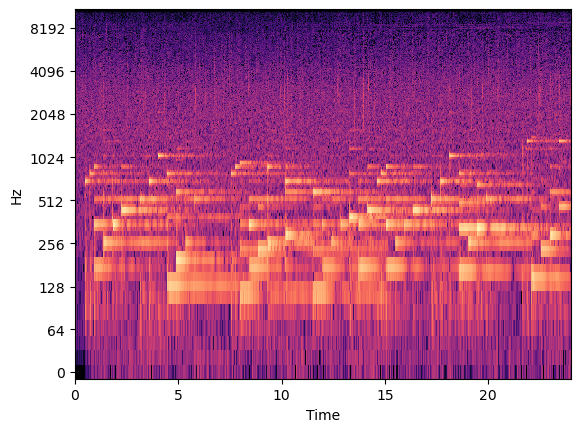

In [16]:
# Magnitude Spectrogram
sound_stft_M = np.abs(sound_stft)

# Plot Spectrogram
D = librosa.amplitude_to_db(sound_stft_M, ref=np.max)
librosa.display.specshow(D, y_axis='log', sr=sr, hop_length=HOP_LENGTH,
                         x_axis='time')

In [17]:
# Phase Spectrogram
sound_stft_A = np.angle(sound_stft)

## Non-negative Matrix Factorisation

In [19]:
def NMF(V, S, beta, t, N):
    i = 1
    cost_value = float('inf')
    F, T = np.shape(V)
    # Initialisation of W and H matrices (random nonnegative entries)
    W = np.abs(np.random.normal(loc=0, scale = 2.5, size=(F,S)))    
    H = np.abs(np.random.normal(loc=0, scale = 2.5, size=(S,T)))

    while cost_value >= t and i <= N:
        # Update of H and W
        H = H * ( W.T @ ( V * ( (W@H)**(beta-2) ) ) ) / ( W.T @ ( (W@H)**(beta-1) ) + 10e-10 )
        W = W * ( ( V * ( (W@H)**(beta-2) ) ) @ H.T ) / ( ( (W@H)**(beta-1) ) @ H.T + 10e-10 )
        
        # Compute cost
        if beta == 0 : cost_value = np.sum( V/(W@H) - math.log10(V/(W@H)) -1 )
        if beta == 1 : cost_value = np.sum( V * np.log10( V / (W @ H) ) + (W @ H - V) )
        if beta == 2 : cost_value = 1/2*np.linalg.norm(W@H-V)

        i += 1
    
    return W, H

In [20]:
# Perform NMF
W, H = NMF(V=sound_stft_M, S=14, beta=1, t=0.01, N=5000)

## Recreate audio signals from Basis Vectors

In [134]:
# Choose basis vectors to recreate signal with

#filters = [0, 3, 28, 24, 21, 18, 11]
#filters = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
#filters = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29]

filters = [0] # F4 piano note
filters = [1] # background noise
filters = [2] # background noise (part of rain sound)
filters = [3] # F5 piano note
filters = [4] # G5 piano note
filters = [5] # C4 piano note with background noise
filters = [6] # background noise
filters = [7] # E4 piano note with background noise
filters = [8] # C6 piano note
filters = [9] # A4 piano note
filters = [10] # G4 piano note
filters = [11] # background noise
filters = [12] # A5 piano note
filters = [13] # background noise
filters = [0,3,4,8,9,10,12]

In [136]:
# Reconstruct
filtered = W[:, filters] @ H[filters, :]
reconst = filtered * np.exp(1j * sound_stft_A)
# Inverse short-time Fourier transform
new_sound = librosa.istft(reconst, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH)

In [138]:
ipd.Audio(new_sound, rate=sr)

In [140]:
ipd.Audio(y_sound, rate=sr)